In [642]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os

In [643]:
LEARNING_RATE2 = 2e-4
LEARNING_RATE1 = 1e-4
BATCH_SIZE = 128
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

In [644]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [645]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [646]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

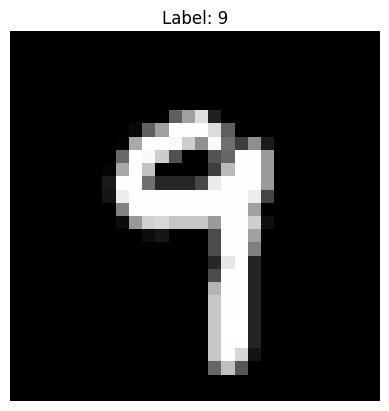

In [647]:
# Load dataset and DataLoader
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Fetch one batch of images
data_iter = iter(loader)
images, labels = next(data_iter)

# Select one image
image = images[0]
label = labels[0]

# Convert the image tensor to a numpy array for displaying
image = image.numpy().squeeze()  # Remove channel dimension (if necessary)

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')
plt.show()

In [648]:
print(loader.dataset.data.shape)

print(dataset.data[0].shape)

torch.Size([60000, 28, 28])
torch.Size([28, 28])


size of image will be 28x28x1

In [649]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            
            # DC
            nn.Conv2d(channels_img, features_d, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 3, 1, 1),     # Divides width and height by 2
            self._block(features_d*2, features_d*4, 3, 2, 1),   # Divides width and height by 2
            self._block(features_d*4, features_d*4, 3, 1, 1),   # Divides width and height by 2
            self._block(features_d*4, features_d*8, 3, 2, 1),   # Divides width and height by 2
            self._block(features_d*8, features_d*8, 3, 1, 1),   # Divides width and height by 2
            self._block(features_d*8, 64, 3, 1, 0),   # Divides width and height by 2

            # FC
            nn.Flatten(),
            nn.Linear(64*5*5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        

    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):

        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)




In [650]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()

        # * 5M parameters
        # self.gen = nn.Sequential(
        #     self._block(z_dim, features_g*8, 3, 1, 1),  # N x f_g*8 x 28 x 28
        #     self._block(features_g*8, features_g*8, 3, 2, 0), # 56 x 56
        #     self._block(features_g*8, features_g*4, 3, 2, 0), # 112 x 112
        #     self._block(features_g*4, features_g*4, 3, 2, 0), # 223 x 223
        #     self._block(features_g*4, features_g*2, 4, 2, 2), # 444 x 444

        #     nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=5, stride=1, padding=2), # 448 x 448
        #     nn.Tanh() # Output = [-1, 1]
        # )

        # *  2.7 M parameters
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*8, 3, 1, 0),  # N x f_g*8 x 28 x 28
            # self._block(features_g*8, features_g*8, 3, 2, 0), # 56 x 56
            self._block(features_g*8, features_g*4, 3, 2, 0), # 112 x 112
            self._block(features_g*4, features_g*4, 3, 2, 1), # 223 x 223
            self._block(features_g*4, features_g*2, 4, 2, 1), # 444 x 444

            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=5, stride=1, padding=1), # 448 x 448
            nn.Tanh() # Output = [-1, 1]
        )

    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
    

    def forward(self, x):
        return self.gen(x)

In [651]:
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

# summary(disc, (1, 28, 28))
summary(gen, (Z_DIM,1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         460,800
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
         LeakyReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,648
       BatchNorm2d-5            [-1, 256, 7, 7]             512
         LeakyReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 256, 13, 13]         589,824
       BatchNorm2d-8          [-1, 256, 13, 13]             512
         LeakyReLU-9          [-1, 256, 13, 13]               0
  ConvTranspose2d-10          [-1, 128, 26, 26]         524,288
      BatchNorm2d-11          [-1, 128, 26, 26]             256
        LeakyReLU-12          [-1, 128, 26, 26]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]           3,201
             Tanh-14            [-1, 1,

In [652]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [653]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    N, in_channels, H, W = 8, 1, 28, 28
    z_dim = 100
    x = torch.randn((N, in_channels, H, W)).to(device)
    disc = Discriminator(in_channels, 8).to(device)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1)

    z = torch.randn((N, z_dim, 1, 1)).to(device)
    gen = Generator(z_dim, in_channels, 8).to(device)
    initialize_weights(gen)
    assert gen(z).shape == (N, in_channels, H, W)

    print("Success")


test()

Success


In [654]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [655]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE1, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE2, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [656]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f'logs3/real')
writer_fake = SummaryWriter(f'logs3/fake')
step = 0

In [662]:

# Define directories to save the weights
SAVE_MODEL_DIR = "checkpoints_torch4"
GEN_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "generator")
DISC_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "discriminator")


# Create directories if they don't exist
os.makedirs(GEN_WEIGHTS_DIR, exist_ok=True)
os.makedirs(DISC_WEIGHTS_DIR, exist_ok=True)


In [681]:
gen.train()
disc.train()

for epoch in range(100, NUM_EPOCHS+100):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        # Train Discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            # print(
            #     f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
            #       Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            # )

            # Display a few images
            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

    if epoch % 5 == 0:
        # Convert images from torch.Tensor to numpy array for plotting
        img_real = img_grid_real.permute(1, 2, 0).cpu().numpy()
        img_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()

        # Plot the real and fake images side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Real Images")
        plt.imshow(img_real)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Fake Images")
        plt.imshow(img_fake)
        plt.axis("off")

        plt.show()

        # Save model weights after each epoch
        gen_path = os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_{epoch+1}.pth")
        disc_path = os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_{epoch+1}.pth")
        
        torch.save(gen.state_dict(), gen_path)
        torch.save(disc.state_dict(), disc_path)
        print(f"Saved Generator and Discriminator weights for epoch {epoch+1}")
        

# Load good Weights

In [684]:

# Load Generator weights
gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_76.pth")))
gen.to(device)  # Move Generator to the device

# Load Discriminator weights
disc.load_state_dict(torch.load(os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_76.pth")))
disc.to(device)  # Move Discriminator to the device

print(f"Loaded Generator and Discriminator weights for epoch {100}")


Loaded Generator and Discriminator weights for epoch 100


C:\Users\pc\AppData\Local\Temp\ipykernel_29944\2839443076.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"

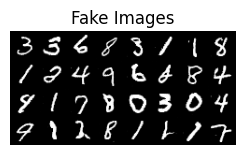

In [685]:
# Display a few images
with torch.no_grad():
    fake = gen(fixed_noise)
    # take out (up to) 32 examples
    img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

     # Convert images from torch.Tensor to numpy array for plotting
    img_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()


    plt.subplot(1, 2, 2)
    plt.title("Fake Images")
    plt.imshow(img_fake)
    plt.axis("off")

    plt.show()